In [ ]:
import sys
sys.path.append('/kaggle/input/alexnet/pytorch/baseline/1')
import torch
import torch.nn as nn
from torchvision import datasets
from baseline.model import AlexNetBaseline, init_params
from baseline.data_transforms import prepreprocess, get_preprocess, get_train_augment
from baseline.train import train
import matplotlib.pyplot as plt
from baseline.eval import top1_k 

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', download=True, transform=prepreprocess)
preprocess = get_preprocess(train_dataset)
train_augment = get_train_augment(train_dataset)
train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=train_augment)

val_dataset = datasets.Imagenette(
    'datasets/imagenette', split='val', size='320px',transform=preprocess)
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [0.5, 0.5])

print(f'Train: {len(train_dataset)}')
print(f'Validation: {len(val_dataset)}')
print(f'Test: {len(test_dataset)}')

Files already downloaded and verified
Mean: [125.35567474365234, 122.99826049804688, 113.91352844238281]
Covar: tensor([[3779.5000, 3389.7288, 3134.5535],
        [3389.7288, 3672.3616, 3586.9302],
        [3134.5535, 3586.9302, 4270.4468]], device='cuda:0')
Eigen values (sqrt): tensor([[ 13.5105],
        [ 29.7229],
        [103.2295]])
Eigen vectors: tensor([[-0.4367, -0.7066,  0.5568],
        [ 0.8152, -0.0491,  0.5771],
        [-0.3804,  0.7059,  0.5975]])
Train: 40000
Cross Validation: 10000
Test: 10000


In [ ]:
model = AlexNetBaseline(len(train_dataset.classes))
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    model = nn.DataParallel(model)
model.to(device)
# initialize parameters
init_params(model)
compiled_model = model
# if torch.cuda.is_available():
#     compiled_model = torch.compile(model)

In [ ]:
costs, val_error_rates, learning_rates = train(
    compiled_model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=128,
    num_epochs=90,
    initial_lr=0.01,
    num_workers=3
)

Epoch 1/90, Cost: 2.304, CV_Error: 90.06%, lr: 0.01, Time: 100.05819773674011
Epoch 2/90, Cost: 2.303, CV_Error: 92.96%, lr: 0.01, Time: 99.85531187057495
Epoch 3/90, Cost: 2.174, CV_Error: 83.57%, lr: 0.01, Time: 99.42600774765015
Epoch 4/90, Cost: 1.892, CV_Error: 86.95%, lr: 0.01, Time: 101.14015412330627
Epoch 5/90, Cost: 1.652, CV_Error: 74.03%, lr: 0.01, Time: 99.47140550613403
Epoch 6/90, Cost: 1.518, CV_Error: 67.79%, lr: 0.01, Time: 99.0596444606781
Epoch 7/90, Cost: 1.391, CV_Error: 74.07%, lr: 0.01, Time: 100.42978310585022
Epoch 8/90, Cost: 1.317, CV_Error: 70.45%, lr: 0.01, Time: 102.94678926467896
Epoch 9/90, Cost: 1.244, CV_Error: 71.04%, lr: 0.01, Time: 103.89094877243042
Epoch 10/90, Cost: 1.177, CV_Error: 75.77%, lr: 0.01, Time: 102.135005235672
Epoch 11/90, Cost: 1.108, CV_Error: 69.74%, lr: 0.01, Time: 104.23509955406189
Epoch 12/90, Cost: 1.052, CV_Error: 67.50%, lr: 0.01, Time: 99.90522336959839
Epoch 13/90, Cost: 1.019, CV_Error: 66.70%, lr: 0.01, Time: 100.85949

In [ ]:
torch.save(model.state_dict(), 'baseline_imagenette10.model.pt')
torch.save(preprocess, 'baseline_imagenette10.preprocess.pt')
torch.save(train_augment, 'baseline_imagenette10.train_augment.pt')

In [ ]:
test_top1, test_top5 = top1_k(compiled_model, test_dataset, k=5)
print(f'Test Top 1: {test_top1}')
print(f'Test Top 5: {test_top5}')

val_top1, val_top5 = top1_k(compiled_model, val_dataset, k=5)
print(f'Val Top 1: {val_top1}')
print(f'Val Top 5: {val_top5}')

train_eval_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', transform=preprocess)
train_top1, train_top5 = top1_k(compiled_model, train_eval_dataset, k=5)
print(f'Val Top 1: {train_top1}')
print(f'Val Top 5: {train_top5}')

Top 1: 0.4903
Top 3: 0.0


Text(0.5, 1.0, 'Costs')

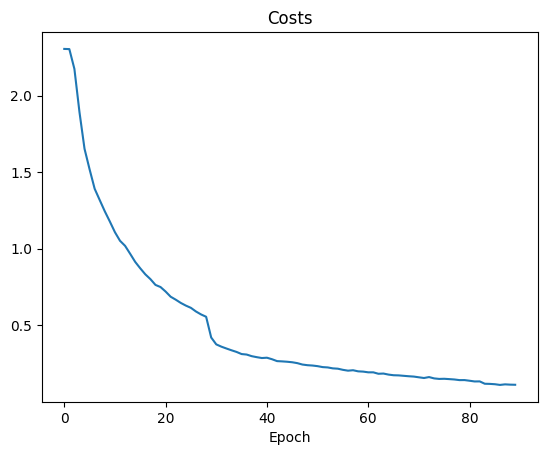

In [ ]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.title('Costs')

Text(0.5, 1.0, 'Cross Validation Error Rates')

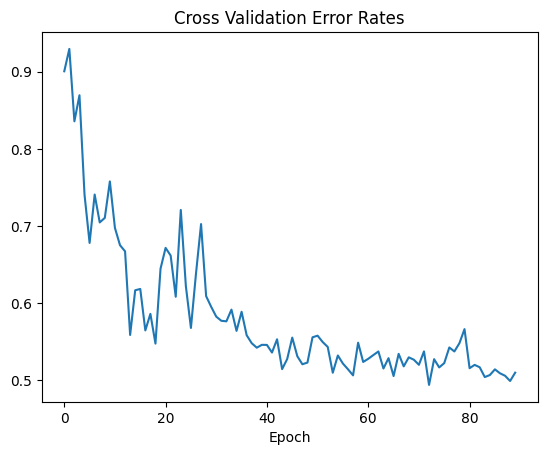

In [ ]:
plt.plot(val_error_rates)
plt.xlabel("Epoch")
plt.title('Cross Validation Error Rates')

Text(0.5, 1.0, 'Learning Rates')

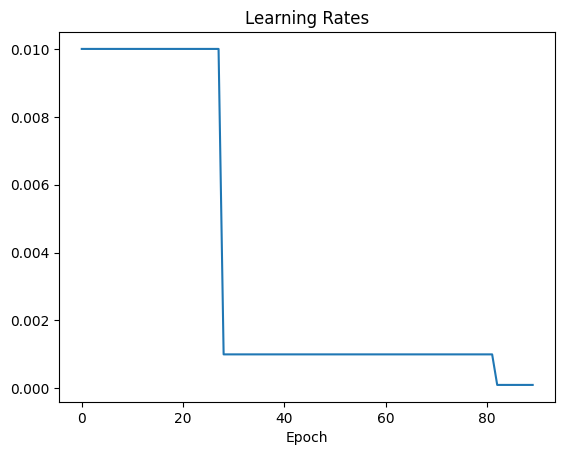

In [ ]:
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.title('Learning Rates')